### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pathlib

from joblib import load

import matplotlib.pyplot as plt
import seaborn as sns

### Interpret best model

In [2]:
model_dir = pathlib.Path("../2.train_model/models/")

log_reg_model_path = pathlib.Path(f"{model_dir}/log_reg_model.joblib")
log_reg_model = load(log_reg_model_path)

### Compile Coefficients Matrix

In [3]:
coefs = np.abs(log_reg_model.coef_)
coefs = pd.DataFrame(coefs).T
coefs.columns = log_reg_model.classes_

print(coefs.shape)
coefs.head()

(1280, 16)


,ADCCM,Anaphase,Apoptosis,Artefact,Binuclear,Elongated,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,OutOfFocus,Polylobed,Prometaphase,SmallIrregular
0,0.011862,0.019952,0.010965,0.016650,0.005141,0.004339,4.405769e-02,0.013558,0.123088,0.038061,0.061276,6.050512e-02,0.000000,0.005036,0.019255,0.172559
1,0.038268,0.000000,0.000000,0.030430,0.052803,0.004324,4.301329e-08,0.003671,0.000000,0.012365,0.009875,1.063972e-07,0.000000,0.000179,0.001719,0.018561
2,0.048010,0.003360,0.001714,0.059247,0.035885,0.033733,3.438937e-02,0.000000,0.042569,0.000957,0.000000,5.028227e-08,0.000000,0.000000,0.069660,0.039836
3,0.020394,0.000000,0.042204,0.026401,0.098106,0.071790,0.000000e+00,0.061451,0.161412,0.000000,0.000000,4.374281e-08,0.002200,0.020280,0.000000,0.009975
4,0.015898,0.015761,0.003009,0.001999,0.033468,0.006133,6.079029e-04,0.011147,0.039301,0.000000,0.040257,0.000000e+00,0.002771,0.025607,0.001267,0.031188


### Save Coefficients Matrix in Tidy Long Format

In [4]:
coefs_save_path = pathlib.Path(f"coefficients/final_model_coefficients.tsv")
coefs_save_path.parent.mkdir(parents=True, exist_ok=True)

# restructure/rename dataframe to tidy long format (see preview below)
tidy_data = coefs.stack()
tidy_data = pd.DataFrame(tidy_data).reset_index(level=[0,1])
tidy_data.columns = ["Feature_Name", "Phenotypic_Class", "Value"]

# add efficientnet_ prefix to all feature names (DeepProfiler prefix for the model used to extract features)
tidy_data["Feature_Name"] = "efficientnet_" + tidy_data["Feature_Name"].astype(str)

tidy_data.to_csv(coefs_save_path, sep="\t")
tidy_data

,Feature_Name,Phenotypic_Class,Value
0,efficientnet_0,ADCCM,0.011862
1,efficientnet_0,Anaphase,0.019952
2,efficientnet_0,Apoptosis,0.010965
3,efficientnet_0,Artefact,0.016650
4,efficientnet_0,Binuclear,0.005141
...,...,...,...
20475,efficientnet_1279,MetaphaseAlignment,0.019258
20476,efficientnet_1279,OutOfFocus,0.012639
20477,efficientnet_1279,Polylobed,0.050846
20478,efficientnet_1279,Prometaphase,0.014370


In [5]:

tidy_data

,Feature_Name,Phenotypic_Class,Value
0,efficientnet_0,ADCCM,0.011862
1,efficientnet_0,Anaphase,0.019952
2,efficientnet_0,Apoptosis,0.010965
3,efficientnet_0,Artefact,0.016650
4,efficientnet_0,Binuclear,0.005141
...,...,...,...
20475,efficientnet_1279,MetaphaseAlignment,0.019258
20476,efficientnet_1279,OutOfFocus,0.012639
20477,efficientnet_1279,Polylobed,0.050846
20478,efficientnet_1279,Prometaphase,0.014370


### Diagrams for interpreting coefficients

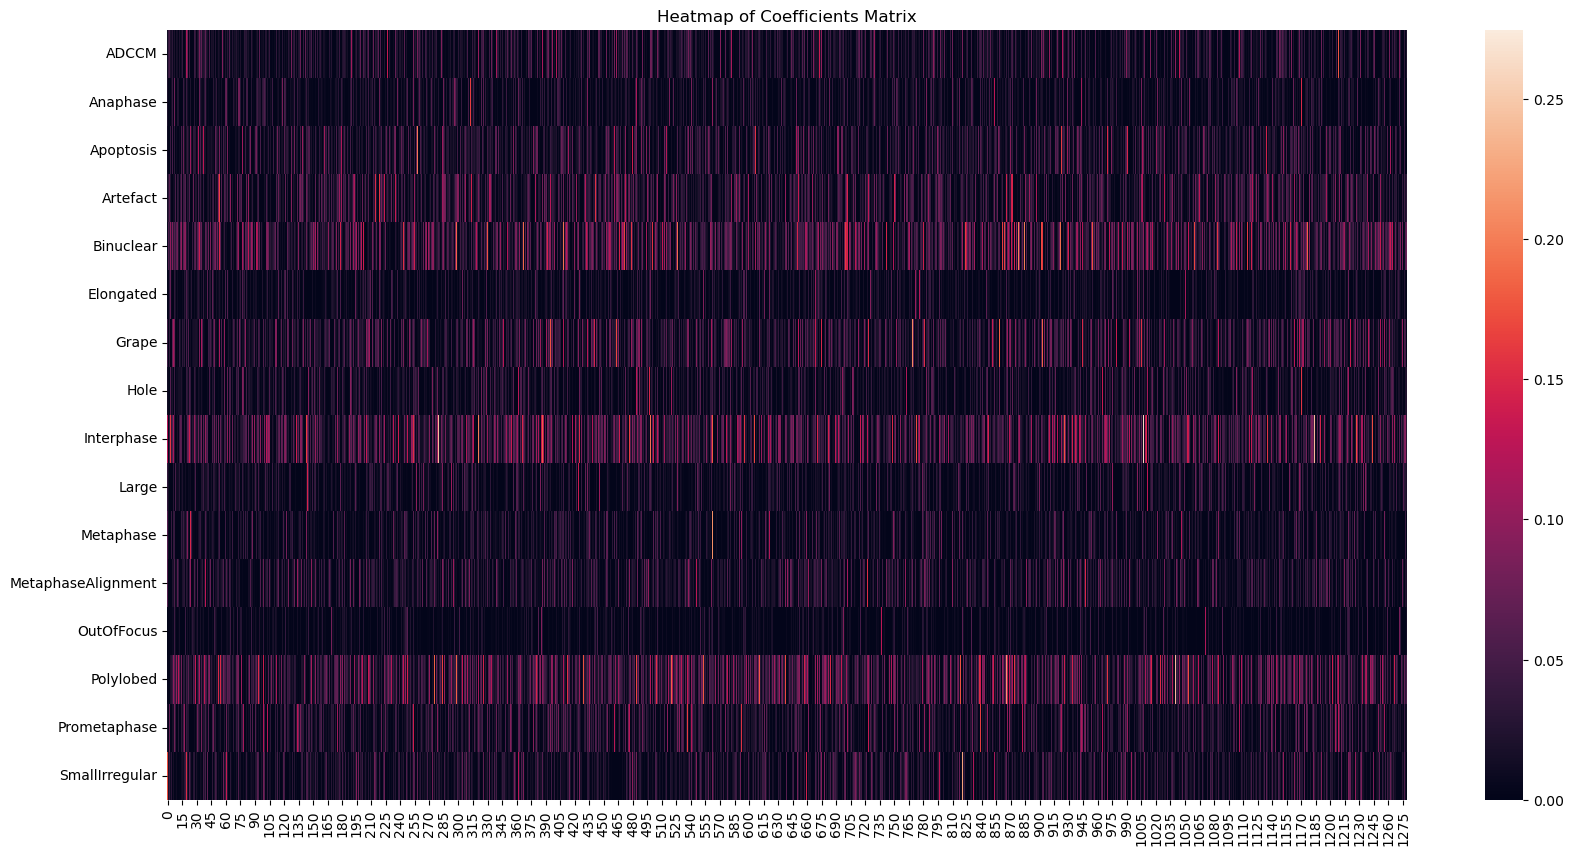

In [6]:
# display heatmap of average coefs
plt.figure(figsize=(20, 10))
plt.title("Heatmap of Coefficients Matrix")
ax = sns.heatmap(data=coefs.T)

/home/roshankern/anaconda3/envs/phenotypic_profiling/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


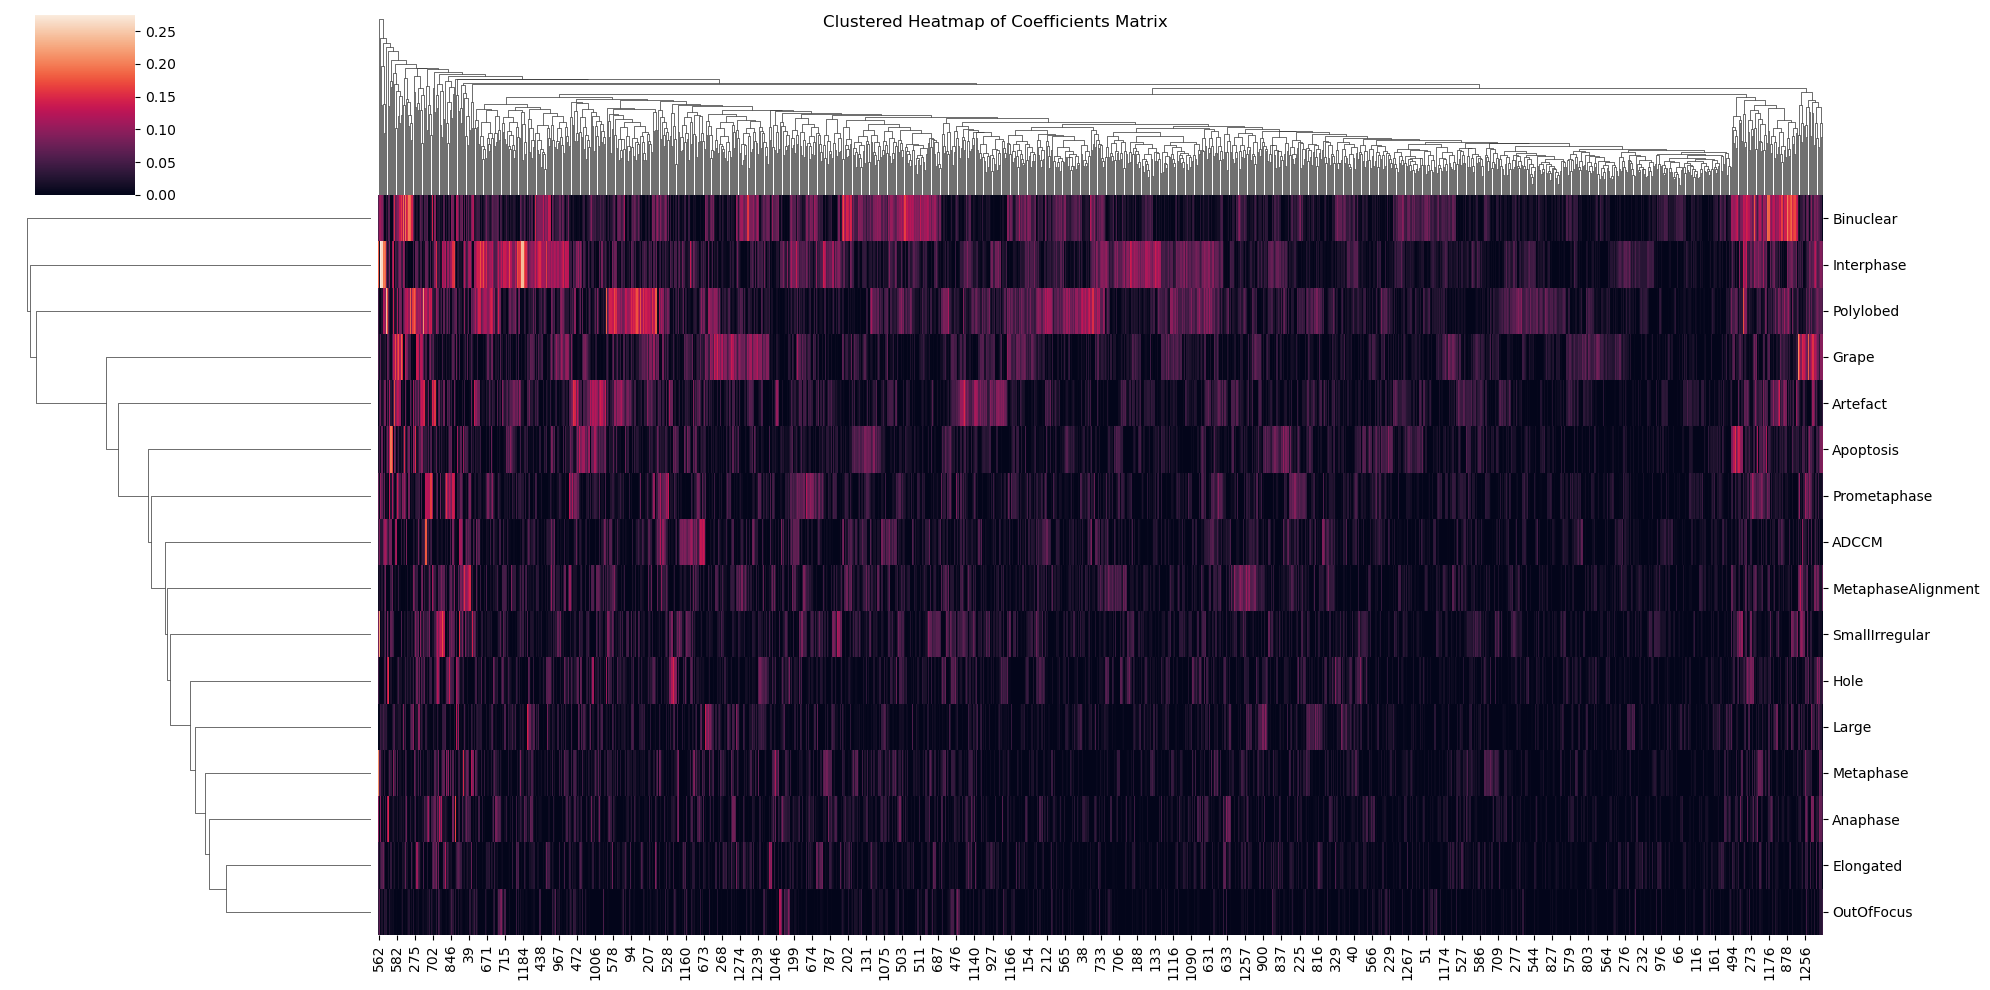

In [7]:
# display clustered heatmap of coefficients
ax = sns.clustermap(data=coefs.T, figsize=(20, 10), row_cluster=True, col_cluster=True)
ax = ax.fig.suptitle("Clustered Heatmap of Coefficients Matrix")

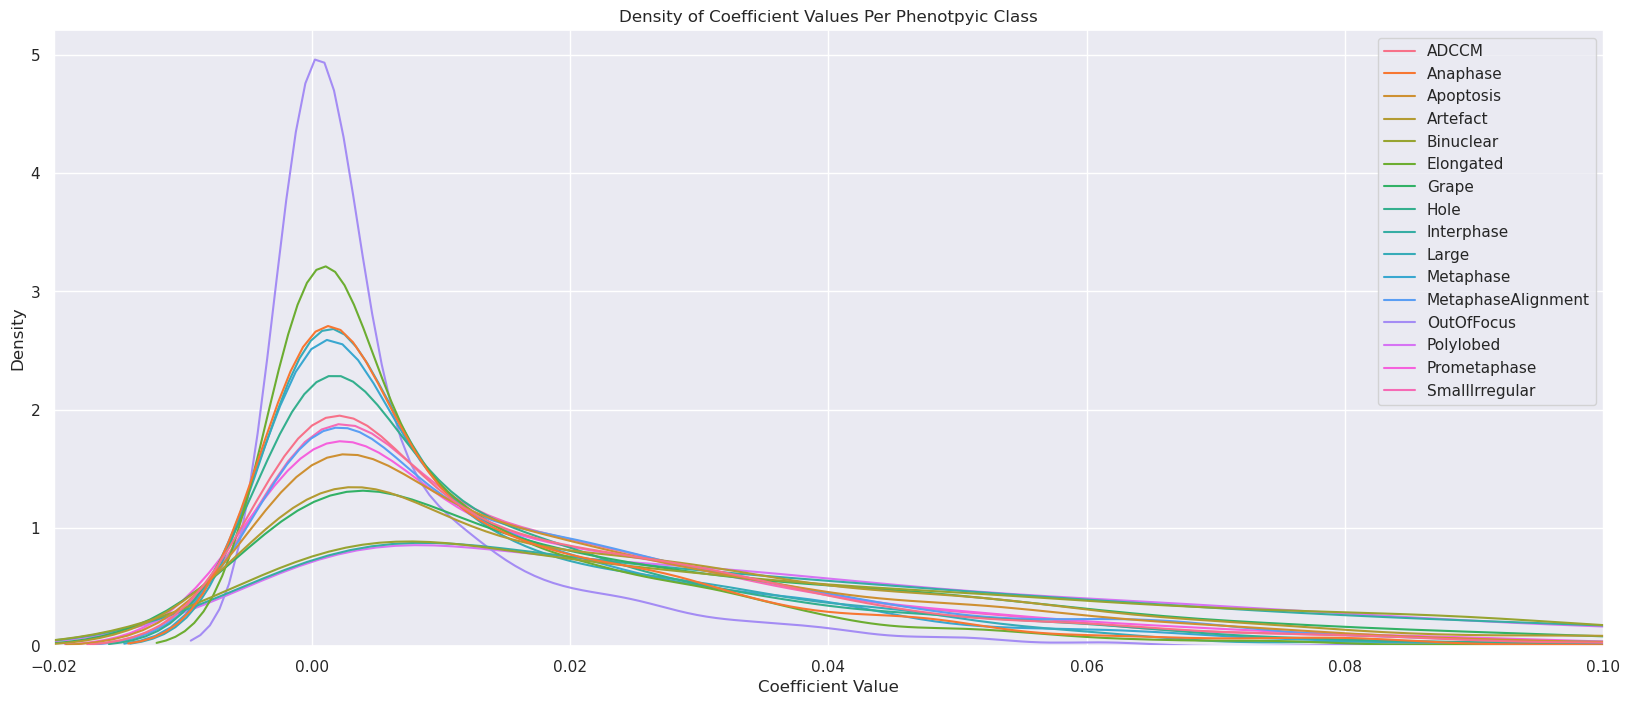

In [8]:
# display density plot for coefficient values of each class
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlim(-0.02, 0.1)
plt.xlabel("Coefficient Value")
plt.ylabel("Density")
plt.title("Density of Coefficient Values Per Phenotpyic Class")
ax = sns.kdeplot(data=coefs)

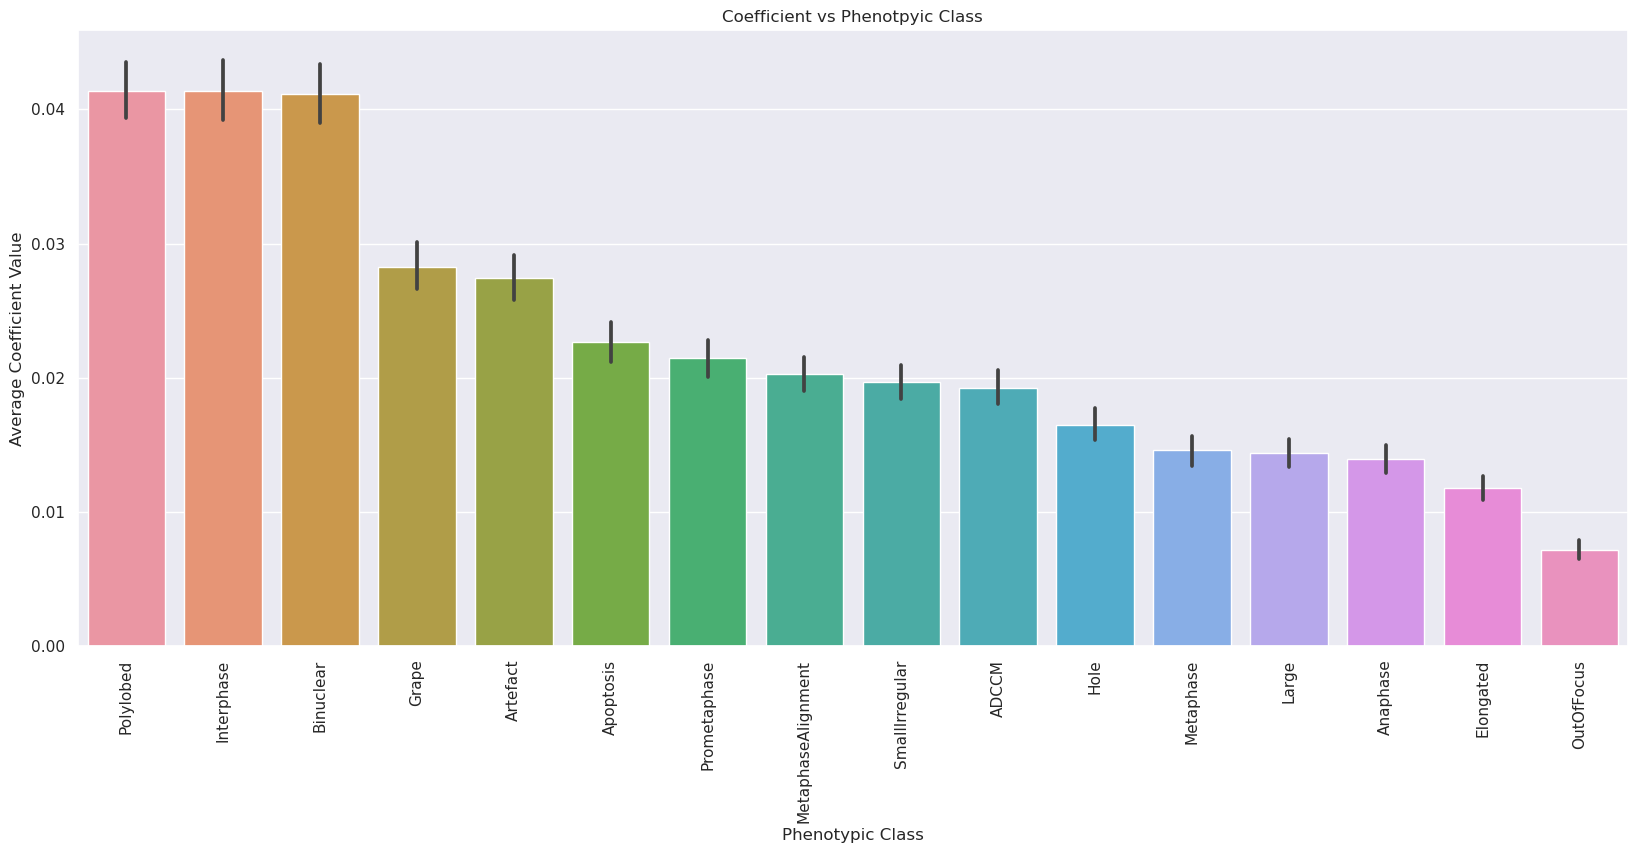

In [9]:
# display average coefficient value vs phenotypic class bar chart
pheno_class_ordered = coefs.reindex(
    coefs.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=pheno_class_ordered)

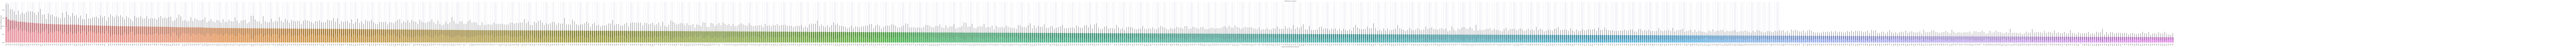

In [10]:
# display average coefficient value vs feature bar chart
feature_ordered = coefs.T.reindex(
    coefs.T.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (500, 8)})
plt.xlabel("Deep Learning Feature Number")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Feature")
plt.xticks(rotation=90)
ax = sns.barplot(data=feature_ordered)

### Interpret shuffled baseline model

In [11]:
shuffled_baseline_log_reg_model_path = pathlib.Path(f"{model_dir}/shuffled_baseline_log_reg_model.joblib")
shuffled_baseline_log_reg_model = load(shuffled_baseline_log_reg_model_path)

### Save Coefficients Matrix in Tidy Long Format

In [12]:
coefs_save_path = pathlib.Path(f"coefficients/shuffled_baseline_model_coefficients.tsv")

# restructure/rename dataframe to tidy long format (see preview below)
tidy_data = coefs.stack()
tidy_data = pd.DataFrame(tidy_data).reset_index(level=[0,1])
tidy_data.columns = ["Feature_Name", "Phenotypic_Class", "Value"]

# add efficientnet_ prefix to all feature names (DeepProfiler prefix for the model used to extract features)
tidy_data["Feature_Name"] = "efficientnet_" + tidy_data["Feature_Name"].astype(str)

tidy_data.to_csv(coefs_save_path, sep="\t")
tidy_data

,Feature_Name,Phenotypic_Class,Value
0,efficientnet_0,ADCCM,0.011862
1,efficientnet_0,Anaphase,0.019952
2,efficientnet_0,Apoptosis,0.010965
3,efficientnet_0,Artefact,0.016650
4,efficientnet_0,Binuclear,0.005141
...,...,...,...
20475,efficientnet_1279,MetaphaseAlignment,0.019258
20476,efficientnet_1279,OutOfFocus,0.012639
20477,efficientnet_1279,Polylobed,0.050846
20478,efficientnet_1279,Prometaphase,0.014370


### Compile Coefficients Matrix

In [13]:
coefs = np.abs(shuffled_baseline_log_reg_model.coef_)
coefs = pd.DataFrame(coefs).T
coefs.columns = shuffled_baseline_log_reg_model.classes_

print(coefs.shape)
coefs.head()

(1280, 16)


,ADCCM,Anaphase,Apoptosis,Artefact,Binuclear,Elongated,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,OutOfFocus,Polylobed,Prometaphase,SmallIrregular
0,0.0,0.0,0.0,0.012240,0.026872,0.0,0.009708,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.025076,0.015191,0.000000
1,0.0,0.0,0.0,0.058407,0.007992,0.0,0.026669,0.0,0.000000,0.023403,0.000000,0.000000,0.068704,0.000000,0.062528,0.000000
2,0.0,0.0,0.0,0.002477,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.001992,0.000000,0.037561,0.024755,0.000000,0.000000
3,0.0,0.0,0.0,0.005847,0.000000,0.0,0.029862,0.0,0.000000,0.000000,0.016067,0.022372,0.022542,0.000000,0.037520,0.000000
4,0.0,0.0,0.0,0.002127,0.063744,0.0,0.027122,0.0,0.027069,0.000000,0.000000,0.000000,0.000000,0.030613,0.000000,0.004223


### Diagrams for interpreting coefficients

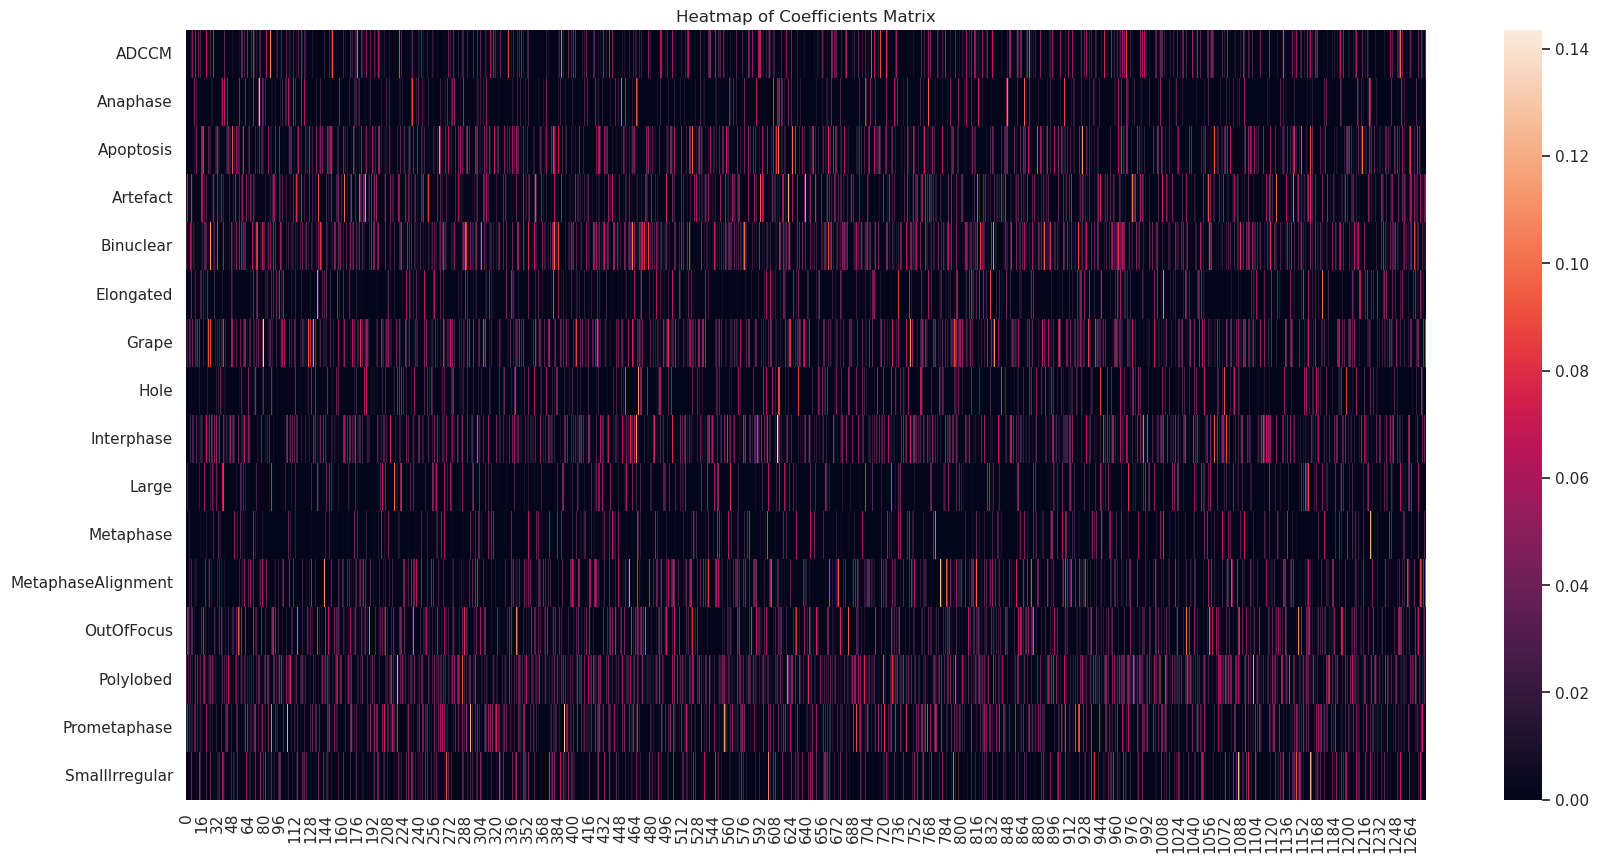

In [14]:
# display heatmap of average coefs
plt.figure(figsize=(20, 10))
plt.title("Heatmap of Coefficients Matrix")
ax = sns.heatmap(data=coefs.T)

/home/roshankern/anaconda3/envs/phenotypic_profiling/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


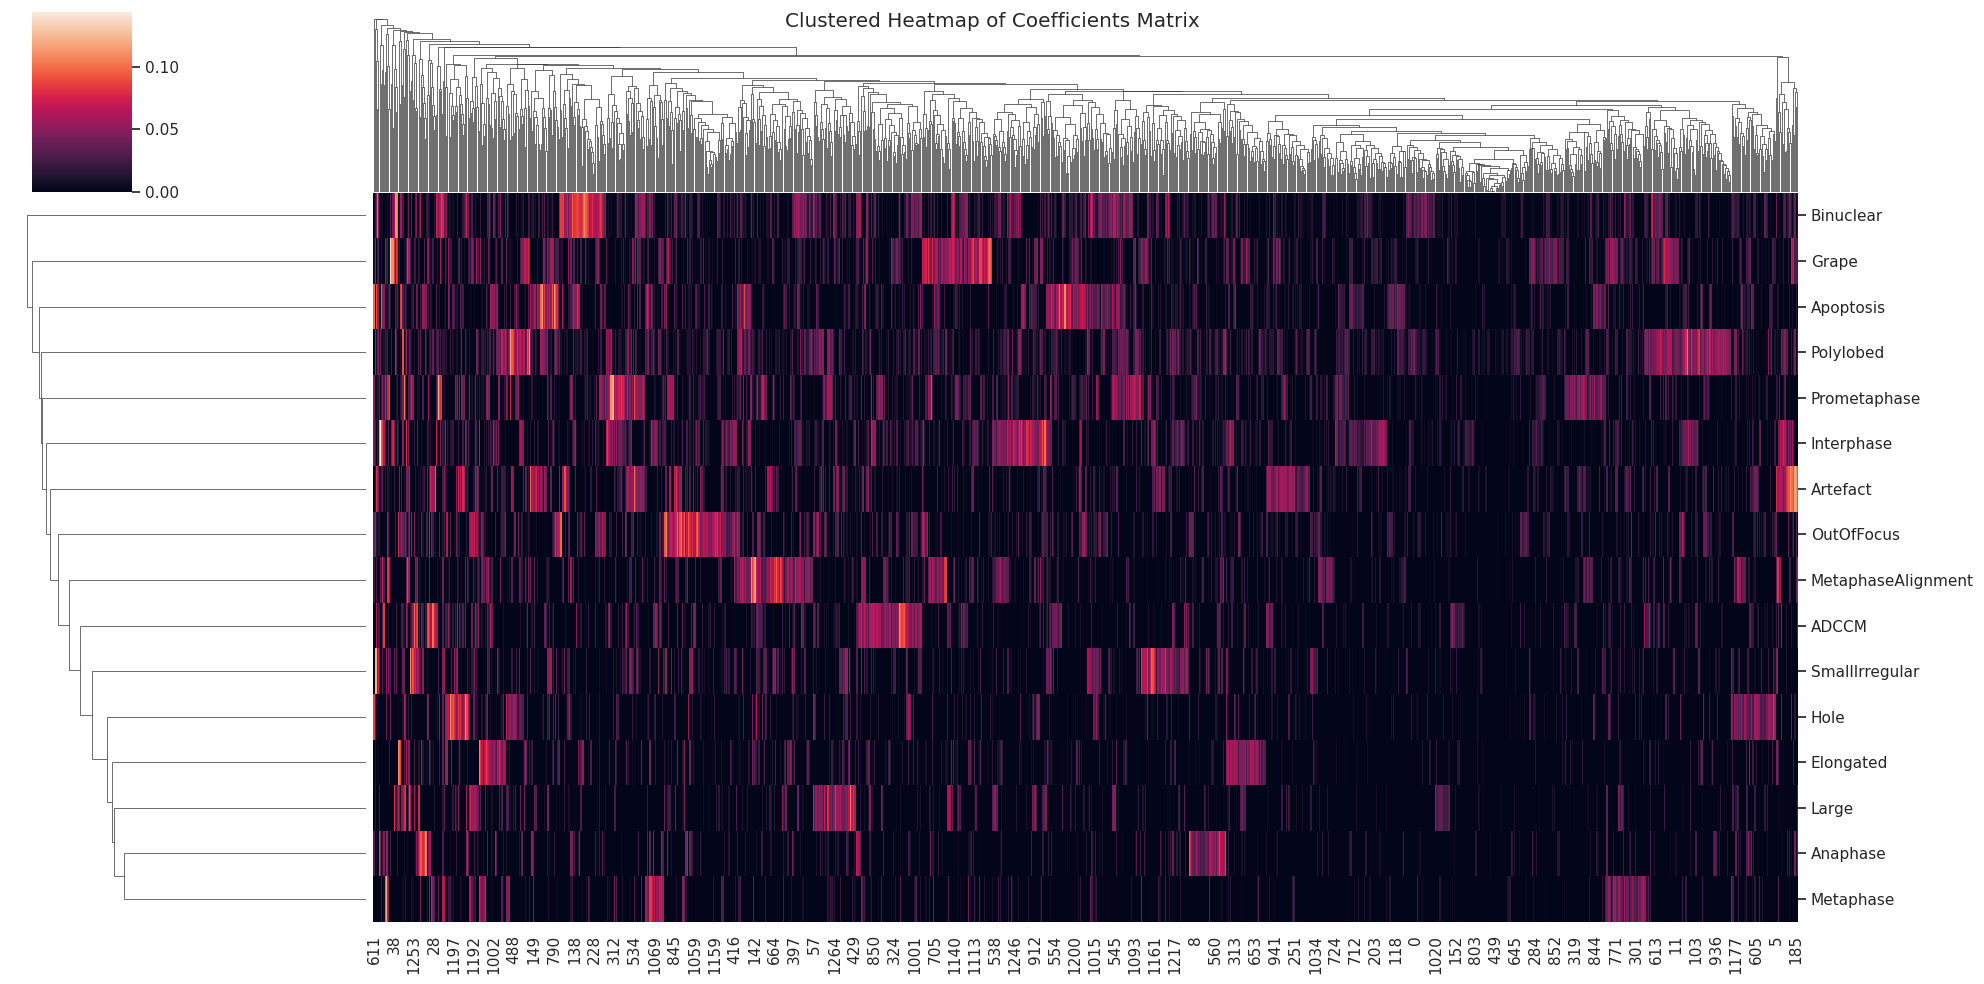

In [15]:
# display clustered heatmap of coefficients
ax = sns.clustermap(data=coefs.T, figsize=(20, 10), row_cluster=True, col_cluster=True)
ax = ax.fig.suptitle("Clustered Heatmap of Coefficients Matrix")

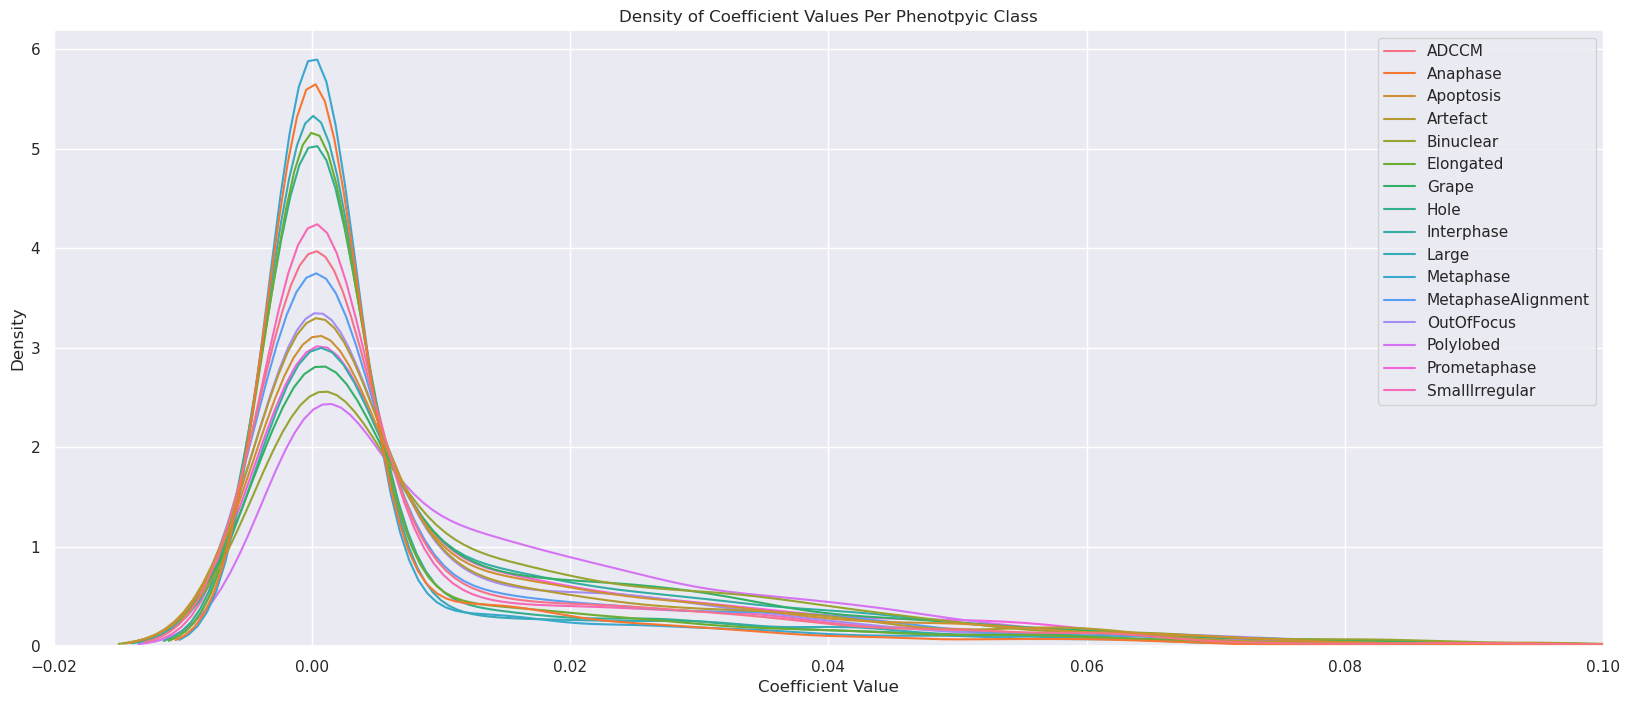

In [16]:
# display density plot for coefficient values of each class
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlim(-0.02, 0.1)
plt.xlabel("Coefficient Value")
plt.ylabel("Density")
plt.title("Density of Coefficient Values Per Phenotpyic Class")
ax = sns.kdeplot(data=coefs)

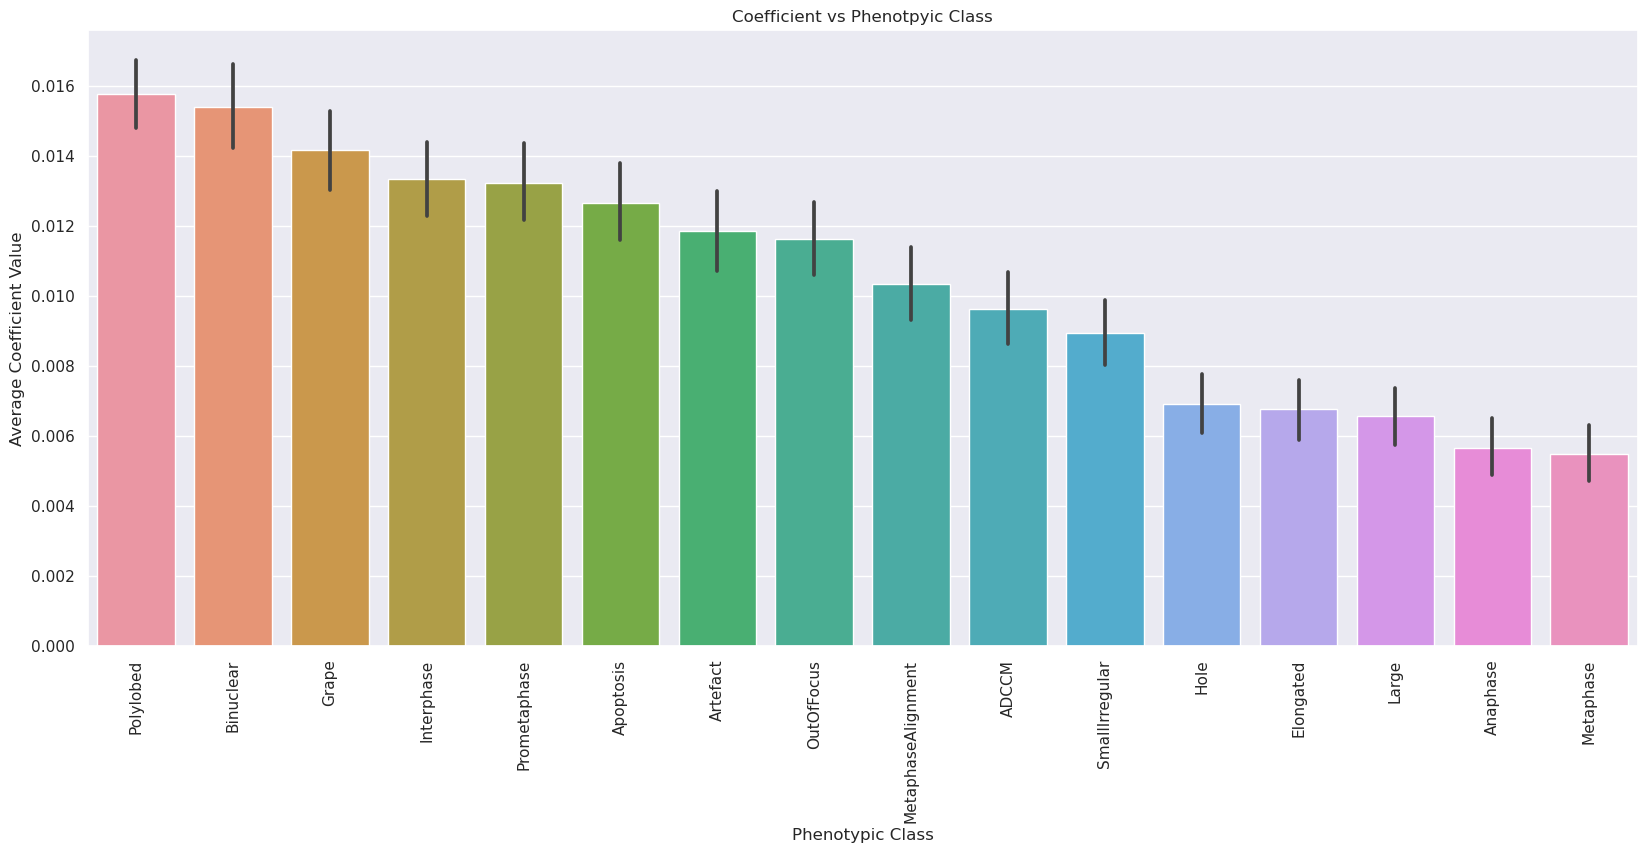

In [17]:
# display average coefficient value vs phenotypic class bar chart
pheno_class_ordered = coefs.reindex(
    coefs.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=pheno_class_ordered)

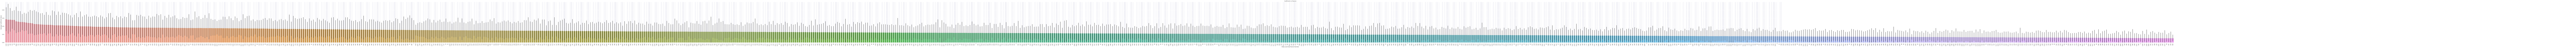

In [18]:
# display average coefficient value vs feature bar chart
feature_ordered = coefs.T.reindex(
    coefs.T.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (500, 8)})
plt.xlabel("Deep Learning Feature Number")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Feature")
plt.xticks(rotation=90)
ax = sns.barplot(data=feature_ordered)